# Can we predict how long a submitted job will sit in the queue? (And what the most important characteristics of a job are that make it sit in the queue?) 

- Response: Queue time = Start – Submit 

- Predictors:  cpu, memory, node (billing?) 

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [15]:
slurm = pd.read_csv("/mnt/scratch/tairaeli/cmse_dat/slurm_cleaned_final.csv")

# data preprocessing
slurm = slurm.drop(columns=['Unnamed: 0'])

# # Filter out rows where 'State' is "Cancelled" or Unknown
slurm = slurm[slurm['State'] != 'Cancelled']
slurm = slurm[slurm['Start']!= 'Unknown']

slurm['Submit'] = pd.to_datetime(slurm['Submit'])
slurm['Start'] = pd.to_datetime(slurm['Start'])

/tmp/ipykernel_88023/3649311792.py:1: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  slurm = pd.read_csv("/mnt/scratch/tairaeli/cmse_dat/slurm_cleaned_final.csv")


In [16]:
# remove na rows in MaxRSS after cleaning data
slurm_clean= slurm.dropna(subset=['MaxRSS'])

In [17]:
# # convert ReqMem to a uniform measurement (assuming 'M' for MB and 'G' for GB and 'K' for KB)
def convert_memory(mem_str):
    '''
    Convert memory units to MegaBytes unit float.
    '''
    if type(mem_str) == float:
        return 0
    if mem_str.endswith('M'):
        return float(mem_str[:-1]) # remove 'M' and convert to float
    elif mem_str.endswith('K'):
        return float(mem_str[:-1]) / 1000
    elif mem_str.endswith('G'):
        return float(mem_str[:-1]) * 1e3  # convert MB to KB
    elif mem_str.endswith('T'):
        return float(mem_str[:-1]) * 1e6 # convert MB to T
    
slurm_clean['ReqMem_MB'] = slurm_clean['ReqMem'].apply(convert_memory)
slurm_clean['MaxRSS_MB'] = slurm_clean['MaxRSS'].apply(convert_memory)

/tmp/ipykernel_88023/1841098687.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slurm_clean['ReqMem_MB'] = slurm_clean['ReqMem'].apply(convert_memory)
/tmp/ipykernel_88023/1841098687.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slurm_clean['MaxRSS_MB'] = slurm_clean['MaxRSS'].apply(convert_memory)


In [18]:
# Function to parse time data columns: TimeLimit and Elapsed
def parse_time_string(time_str):
    """Convert a time string into a timedelta object."""
    days = 0
    if type(time_str) == float:
        return timedelta(days=0, hours=0, minutes=0, seconds=0)
    if '-' in time_str:
        days, time_str = time_str.split('-')
        days = int(days)

    parts = time_str.split(':')
    hours, minutes, seconds = map(int, parts) if len(parts) == 3 else (int(parts[0]), int(parts[1]), 0)
    return timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)

# Convert Timelimit and Elapsed to timedeltas
slurm_clean['Timelimit'] = slurm_clean['Timelimit'].apply(parse_time_string)
slurm_clean['Elapsed'] = slurm_clean['Elapsed'].apply(parse_time_string)

/tmp/ipykernel_88023/1674833237.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slurm_clean['Timelimit'] = slurm_clean['Timelimit'].apply(parse_time_string)
/tmp/ipykernel_88023/1674833237.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slurm_clean['Elapsed'] = slurm_clean['Elapsed'].apply(parse_time_string)


In [19]:
slurm_clean.head()

,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,AssocID,...,AllocCPUS,ReqMem,MaxRSS,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES,ReqMem_MB,MaxRSS_MB
201,87461884,user_600,group_090,2023-09-08 18:34:09,2023-09-29 21:30:06,2023-10-01T05:42:37,1 days 08:12:31,COMPLETED,account_011,assocID_575,...,64,32G,4500K,4,4,"lac-[084-086,193]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.500
202,87461892,user_600,group_090,2023-09-08 18:34:11,2023-09-30 00:16:32,2023-10-01T06:19:40,1 days 06:03:08,COMPLETED,account_011,assocID_575,...,64,32G,4540K,4,4,"lac-[142,192,345,349]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.540
203,87461900,user_600,group_090,2023-09-08 18:34:13,2023-09-30 01:07:56,2023-10-01T06:33:57,1 days 05:26:01,COMPLETED,account_011,assocID_575,...,64,32G,4536K,4,4,"lac-[080-081,342-343]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.536
204,87461908,user_600,group_090,2023-09-08 18:34:15,2023-09-30 03:06:56,2023-10-01T09:16:02,1 days 06:09:06,COMPLETED,account_011,assocID_575,...,64,32G,4540K,4,4,"lac-[031,136,346-347]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.540
205,87461916,user_600,group_090,2023-09-08 18:34:18,2023-09-30 08:13:45,2023-10-01T14:30:28,1 days 06:16:43,COMPLETED,account_011,assocID_575,...,64,32G,4604K,4,4,"lac-[083,196,344,348]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.604


In [20]:
# Calculate queutime in minutes
slurm_clean["QueueTime (Minutes)"] = (slurm_clean['Start']- slurm_clean['Submit']).dt.total_seconds()/60
slurm_clean['Timelimit (Minutes)'] = slurm_clean['Timelimit'].dt.total_seconds()/60
slurm_clean.head(5)

/tmp/ipykernel_88023/3306242306.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slurm_clean["QueueTime (Minutes)"] = (slurm_clean['Start']- slurm_clean['Submit']).dt.total_seconds()/60
/tmp/ipykernel_88023/3306242306.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slurm_clean['Timelimit (Minutes)'] = slurm_clean['Timelimit'].dt.total_seconds()/60


,JobID,User,Group,Submit,Start,End,Elapsed,State,Account,AssocID,...,MaxRSS,ReqNodes,NNodes,NodeList,ReqTRES,AllocTRES,ReqMem_MB,MaxRSS_MB,QueueTime (Minutes),Timelimit (Minutes)
201,87461884,user_600,group_090,2023-09-08 18:34:09,2023-09-29 21:30:06,2023-10-01T05:42:37,1 days 08:12:31,COMPLETED,account_011,assocID_575,...,4500K,4,4,"lac-[084-086,193]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.500,30415.950000,2160.0
202,87461892,user_600,group_090,2023-09-08 18:34:11,2023-09-30 00:16:32,2023-10-01T06:19:40,1 days 06:03:08,COMPLETED,account_011,assocID_575,...,4540K,4,4,"lac-[142,192,345,349]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.540,30582.350000,2160.0
203,87461900,user_600,group_090,2023-09-08 18:34:13,2023-09-30 01:07:56,2023-10-01T06:33:57,1 days 05:26:01,COMPLETED,account_011,assocID_575,...,4536K,4,4,"lac-[080-081,342-343]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.536,30633.716667,2160.0
204,87461908,user_600,group_090,2023-09-08 18:34:15,2023-09-30 03:06:56,2023-10-01T09:16:02,1 days 06:09:06,COMPLETED,account_011,assocID_575,...,4540K,4,4,"lac-[031,136,346-347]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.540,30752.683333,2160.0
205,87461916,user_600,group_090,2023-09-08 18:34:18,2023-09-30 08:13:45,2023-10-01T14:30:28,1 days 06:16:43,COMPLETED,account_011,assocID_575,...,4604K,4,4,"lac-[083,196,344,348]","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4","billing=4980,cpu=64,gres/gpu=4,mem=32G,node=4",32000.0,4.604,31059.450000,2160.0


In [21]:
slurm_clean.columns

Index(['JobID', 'User', 'Group', 'Submit', 'Start', 'End', 'Elapsed', 'State',
       'Account', 'AssocID', 'Partition', 'Timelimit', 'UserCPU', 'SystemCPU',
       'TotalCPU', 'CPUTime', 'CPUTimeRAW', 'ReqCPUS', 'AllocCPUS', 'ReqMem',
       'MaxRSS', 'ReqNodes', 'NNodes', 'NodeList', 'ReqTRES', 'AllocTRES',
       'ReqMem_MB', 'MaxRSS_MB', 'QueueTime (Minutes)', 'Timelimit (Minutes)'],
      dtype='object')

/mnt/home/tairaeli/anaconda3/envs/data_sc/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


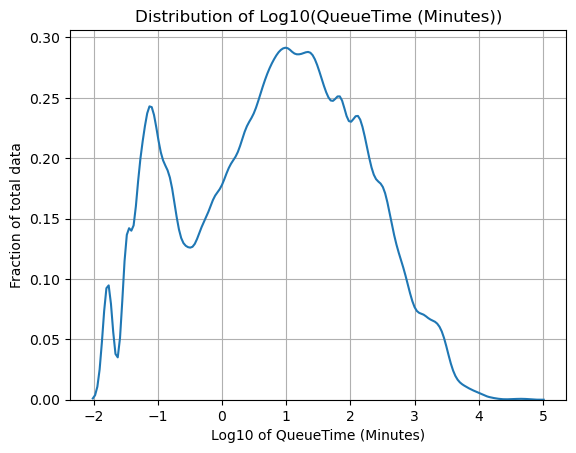

In [25]:
sns.kdeplot(np.log10(slurm_clean['QueueTime (Minutes)']))
plt.xlabel('Log10 of QueueTime (Minutes)')
plt.ylabel('Fraction of total data')
plt.title('Distribution of Log10(QueueTime (Minutes))')
plt.grid(True) 
plt.show()

# Predictive modeling

**Random Forest Model**

In [27]:
# prepare the dataset for training
X = slurm_clean[['ReqCPUS','ReqMem_MB','ReqNodes','Timelimit (Minutes)']]
y = slurm_clean['QueueTime (Minutes)']

# splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=42)

# standarize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a random Forest Regressor 
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# predict on the test set
y_pred = model.predict(X_test_scaled)

# evaluate the model;  
print("Mean Absolute Error", mean_absolute_error(y_test,y_pred))

# Calculate R2 score for accuracy
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Mean Absolute Error 130.49159462418257
R2 Score: 0.7672749392555288
Root Mean Squared Error: 454.42244204604555


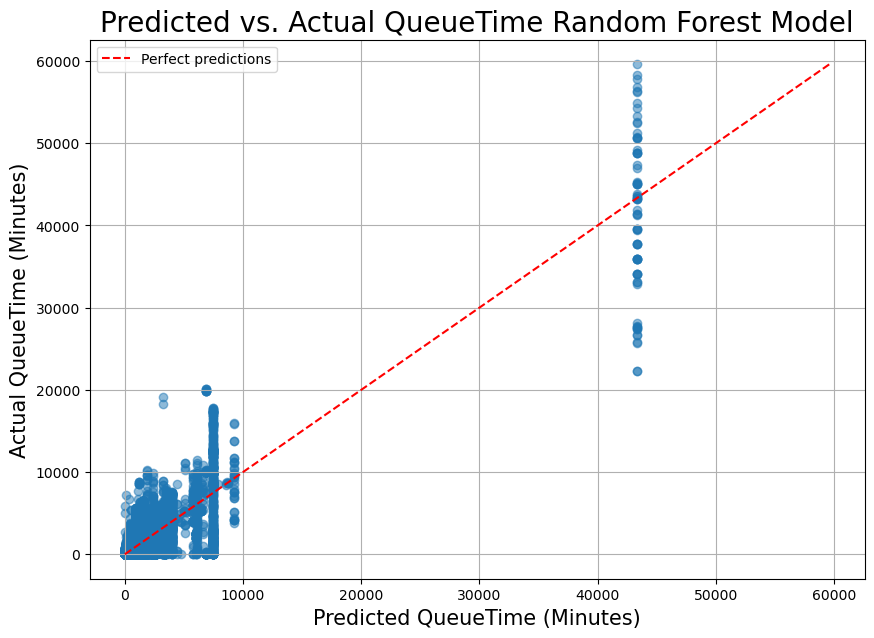

In [30]:
# Plotting both the identity line (for reference) and the scatter plot
plt.figure(figsize=(10, 7))  # Optional: you can adjust the figure size as needed

# Identity line for reference (where perfect predictions would lie)
array = np.arange(0, np.max([y_test.max(), y_pred.max()])+1)  # Adjust the range based on your data
plt.plot(array, array, 'r--', label='Perfect predictions')  # Red dashed line for reference

# Scatter plot of Predicted vs. Actual values
plt.scatter(y_pred, y_test, alpha=0.5)  # Alpha for marker opacity

# Adding title and axis labels
plt.title('Predicted vs. Actual QueueTime Random Forest Model', fontsize=20)
plt.xlabel('Predicted QueueTime (Minutes)', fontsize=15)
plt.ylabel('Actual QueueTime (Minutes)', fontsize=15)

# Adding a legend
plt.legend()

# Show grid
plt.grid(True)

# Display the plot
plt.show()